In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
import seaborn as sns

import scipy.optimize as opt
import Quandl

from helpers import get_adj_close

import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.api import qqplot
from statsmodels.graphics import tsaplots
from statsmodels.tsa import *

/Users/bbahmany/Main/Programming/Git/quantitative-finance/qf-env/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
%matplotlib inline
sns.set_style("whitegrid", {'axes.edgecolor': '.6', 
                            'axes.facecolor': '0.9', 
                            'grid.color': '.82', 
                            'legend.frameon': True,
                            'axes.labelsize': 'small'})
#sns.set_context("talk")

In [4]:
basket = get_adj_close(['FB', 'AAPL'], start="2013-01-01", ratio=False)

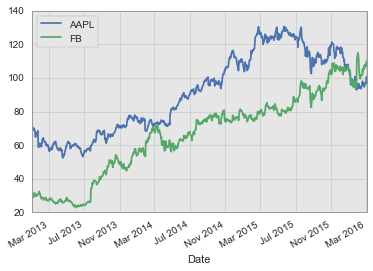

In [5]:
basket.plot()

In [6]:
def get_lagged_returns(series, window):
    """
    Args:
        series (ndarray): the time series to get the lagged return ratios
        window (int): number of trading weeks to use
        
    Return (ndarray): y(t)/y(t-1) over the weeks specified
    """
    
    return series[-window*5:].values/series[-((window*5)+1):-1].values

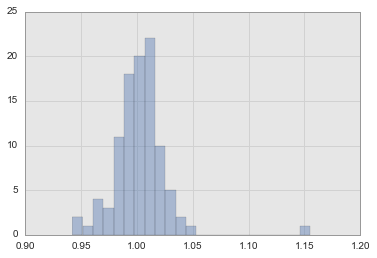

In [7]:
sns.distplot(get_lagged_returns(basket['FB'],20), kde=False);

In [79]:
# mu = 1
# sigma2 = 1
# x = np.random.lognormal(mu, np.sqrt(sigma2), 5000)

In [8]:
def neg_log_llh(theta, data):
    """
    Args:
        theta (list): the params [mu, sigma**2]
        data (ndarray): data points to be fit by log normal distribution
        
    Return (double): negative log-likelihood for the log normal.
    """
    
    mu, sigma = theta[0], np.sqrt(theta[1])
    neg_log_llhs = np.log(data*sigma*np.sqrt(2*np.pi)) + ((np.log(data)-mu)**2/(2*(sigma**2))) 
    
    return neg_log_llhs.sum()

In [13]:
def mle_log_norm(data, init_theta=[1,1]):
    """
    Args:
        theta (list): the params [mu, sigma**2]
        data (ndarray): data points to be fit by log normal distribution
    
    Return (list): mu, sigma**2 for fitted log normal params
    """
    
    fit = opt.minimize(neg_log_llh, init_theta, data, method='Nelder-Mead')
    return fit.x

In [14]:
mle_log_norm(get_lagged_returns(basket['FB'],20))

array([ 0.00173433,  0.0005644 ])

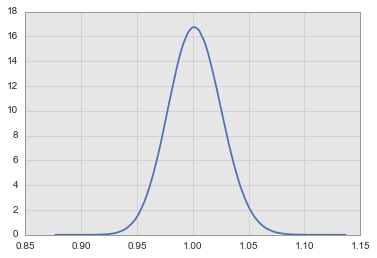

In [15]:
sns.distplot(np.random.lognormal(0.00173433, np.sqrt(0.0005644), 10000000), kde=True, hist=False);

In [16]:
def simulate_random_walk(series, window=10, ahead=50):
    
    mu, sigma2 = mle_log_norm( get_lagged_returns(series, window) )
    forcast = np.random.lognormal(mu, np.sqrt(sigma2), ahead)
    forcast[0] *= series[-1:]
    
    return np.cumprod(forcast)

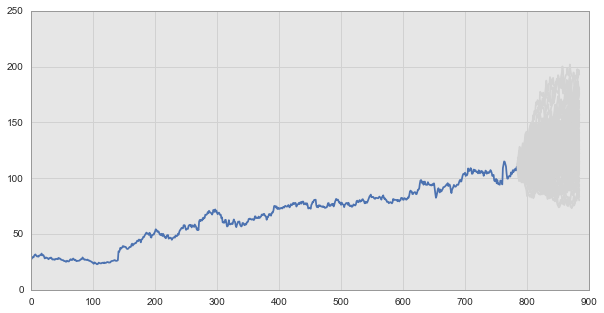

In [32]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,basket.FB.count()), basket.FB)
for i in range(100):
    plt.plot(np.arange(785, 885), simulate_random_walk(basket.FB, 20, 100), 'lightgrey')

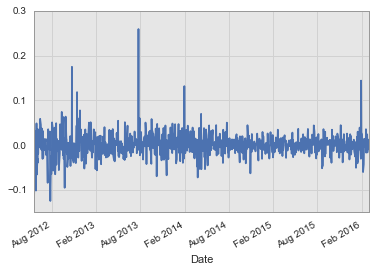

In [6]:
fb.close.map(lambda x:np.log(x)).diff().dropna().plot()

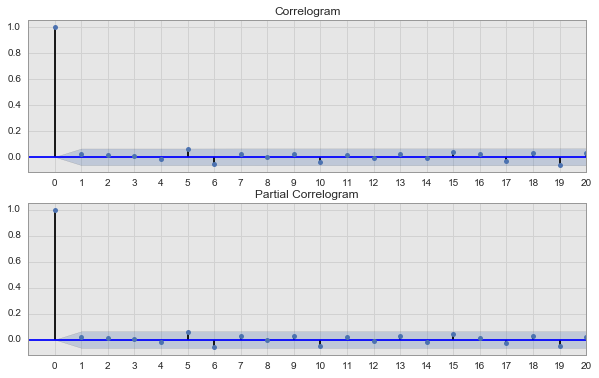

In [7]:
plot_correlograms(fb.close.map(lambda x:np.log(x)).diff().dropna(), 20)

In [ ]:
def plot_correlograms(series, limit=50):
    fig = plt.figure(figsize=(10,6));
    ax1 = fig.add_subplot(211);
    fig = sm.graphics.tsa.plot_acf(series, lags=limit, ax=ax1);
    plt.title('Correlogram');
    plt.xticks(np.arange(0,limit+1,1))
    plt.xlim([-1,limit])
    
    ax2 = fig.add_subplot(212);
    fig = sm.graphics.tsa.plot_pacf(series, lags=limit, ax=ax2);
    plt.title('Partial Correlogram');
    plt.xticks(np.arange(0,limit+1,1))
    plt.xlim([-1,limit])

In [32]:
def moving_average(ts, theta1):
    ma = pd.Series(index=ts.index, data=np.repeat(0, ts.size))
    ma[0] = ts[0]
  
    for idx in range(1,ts.size):
        ma[idx] = theta1*ts[idx-1]
      
    return ma

In [33]:
arima1 = arima_model.ARIMA(fb.close, order=[0,1,1]).fit()

In [34]:
arima1.params

const            0.073164
ma.L1.D.close    0.025695
dtype: float64

In [35]:
resid = arima1.resid

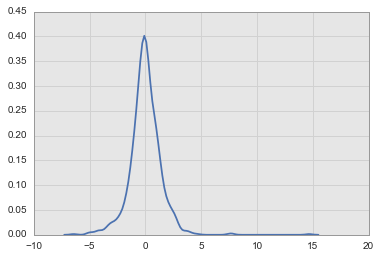

In [41]:
sns.kdeplot(resid);

In [43]:
predict = arima1.predict('2014', '2015', dynamic=True)

/Users/bbahmany/Main/Programming/Git/quantitative-finance/qf-env/lib/python3.5/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)
